# Машинное обучение, ФКН ВШЭ

# Практическое задание 7

## Общая информация

Дата выдачи: 11.05.2017

Срок сдачи: 23:59MSK 28.05.2017

### О задании

Практическое задание 7 посвящено задаче построения рекомендаций и различным подходам к её решению. В рамках данного задания вы:
 * опробуете различные подходы к построению рекомендаций в задаче рекомендаций фильмов;
 * оцените качество работы различных подходов на различных группах пользователей, изучите наличие известных недостатков рекомендательных систем;
 * познакомитесь со способами оценивания качества работы полученных рекомендательных систем, изучите их достоинства и недостатки.
 
### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW7_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW7_IvanovII.ipynb*). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

## Рекомендательные системы

В этой лабораторной работе будет рассмотрена задача предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Мы будем работать с датасетом [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

На основании этих данных необходимо построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

## Оценивание качества рекомендаций

Будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.

Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.

Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (0.5 балла)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен. Отметим, что в этом случае для валидационной и тестовой матриц в каждой строке должно быть ровно 5 ненулевых значений. Рассматривайте только тех пользователей, которые поставили оценки $\ge 11$ фильмам.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные об оценках фильмов пользователями

In [3]:
ratings = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')
ratings.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


Так как ID пользователей и ID фильмов в нашем датасете идут не подряд, изменим их, чтобы разреженные матрицы были поменьше (каждый userID заменим на его место в отсортированном списке всех наших userID, то же самое сделаем с movieID).

In [4]:
new_userIDs = {}
userIDs = list(set(ratings['userID']))
userIDs.sort()
for i in range(len(userIDs)):
    new_userIDs[userIDs[i]] = i

new_movieIDs = {}
movieIDs = list(set(ratings['movieID']))
movieIDs.sort()
for i in range(len(movieIDs)):
    new_movieIDs[movieIDs[i]] = i
ratings['compressed_userID'] = [new_userIDs[x] for x in ratings['userID']]
ratings['compressed_movieID'] = [new_movieIDs[x] for x in ratings['movieID']]

Сгруппируем наш датасет по пользователям, используя DataFrame.groupby, и определим оценки, идущие в обучающую, валидационную и тестовую выборки.

In [5]:
train_df = pd.DataFrame(columns=ratings.columns)
val_df = pd.DataFrame(columns=ratings.columns)
test_df = pd.DataFrame(columns=ratings.columns)
grouped = list(ratings.groupby('compressed_userID'))
for item in grouped:
    df = item[1]
    if df.shape[0] < 11:
        continue
    df = df.sort_values(by='timestamp')
    to_test = df[-5:]
    to_val = df[-10:-5]
    to_train = df[:-10]
    train_df = train_df.append(to_train)
    test_df = test_df.append(to_test)
    val_df = val_df.append(to_val)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(834468, 6)
(10565, 6)
(10565, 6)


Наконец, сформируем разреженные матрицы для обучающей, тестовой и валидационной выборок.

In [6]:
from scipy import sparse

In [7]:
n_users = len(new_userIDs)
n_movies = len(new_movieIDs)

In [8]:
train_sm = sparse.csr_matrix((train_df['rating'].values, \
                            (train_df['compressed_userID'].values,\
                             train_df['compressed_movieID'].values)),\
                            shape=(n_users, n_movies))
test_sm = sparse.csr_matrix((test_df['rating'].values, \
                            (test_df['compressed_userID'].values,\
                             test_df['compressed_movieID'].values)),\
                            shape=(n_users, n_movies))
val_sm = sparse.csr_matrix((val_df['rating'].values, \
                            (val_df['compressed_userID'].values,\
                             val_df['compressed_movieID'].values)),\
                            shape=(n_users, n_movies))

Для измерения качества рекомендаций в этом задании будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k вычисляется следующим образом:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Для оценки качества рекомендаций также можно использовать метрику качества ранжирования. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка.

Как и ранее, отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Напомним, что

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

В рамках данного практического задания положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (1 балл)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [85]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = np.array(y_predicted)
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    else:
        y_true = np.array(y_true)
    sum_rmses = 0
    n = y_true.shape[0]
    diff_sqrs = (y_predicted - y_true) ** 2
    argsort = y_predicted.argsort(axis=1)[:, ::-1]
    for i in range(n):
        most_recommended = argsort[i][:k]
        sum_rmses += np.sqrt(diff_sqrs[i][most_recommended].mean())
    return sum_rmses / n

def ndcg_score(y_true, y_predicted, k=5):
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = np.array(y_predicted)
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    else:
        y_true = np.array(y_true)
    g = lambda r: 2 ** r - 1
    d = lambda i: 1 / np.log2(i + 2)
    max_dcg = g(5) * d(np.arange(k)).sum()
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    n, m = y_true.shape
    dcg = []
    argsort = y_predicted.argsort(axis=1)[:, ::-1]
    for i in range(n):
        most_recommended = argsort[i][:k]
        true_ratings = y_true[i][most_recommended]
        dcg.append(np.sum(g(true_ratings) * d(np.arange(k))))
    dcg = np.array(dcg)
    return (dcg / max_dcg).mean()

**3. (0.5 балла)** Разделите индексы пользователей в матрицах из п.1 на 3 группы:
1. пользователи, оценившие менее 20 фильмов;
2. 50 случайных пользователей, оценивших фильмы, имеющие не более 5 оценок;
3. все остальные пользователи.

In [10]:
less_20_rates = [x[0] for x in grouped if x[1].shape[0] < 20]
print(len(less_20_rates))

0


Первая группа пуста - каждый пользователь оценил хотя бы 20 фильмов.

Отберем вторую группу. Для этого посмотрим, сколько раз был оценен каждый фильм.

In [11]:
import collections

In [12]:
all_ratings_sm = sparse.csr_matrix((ratings['rating'], (ratings['compressed_userID'], ratings['compressed_movieID'])))
ratings_by_movies = all_ratings_sm.nonzero()[1]
counter = collections.Counter(ratings_by_movies)
rarely_rated = [i for i in range(n_movies) if counter[i] <= 5]
print('Из {} фильмов {} имеют не более 5 оценок'.format(n_movies, len(rarely_rated)))

Из 10109 фильмов 2248 имеют не более 5 оценок


In [13]:
our_users = set()
for movie in rarely_rated:
    for user in all_ratings_sm.getcol(movie).tocsc().indices:
        our_users.add(user)
print('Всего {} пользователей, оценивших непопулярные фильмы'.format(len(our_users)))

Всего 916 пользователей, оценивших непопулярные фильмы


In [14]:
import random
group2 = set(random.sample(our_users, 50))
group3 = set(range(n_users)) - group2

Для каждой группы сделаем отдельные матрицы.

In [15]:
group2_train_sm = train_sm[list(group2)]
group2_test_sm = test_sm[list(group2)]
group2_val_sm = val_sm[list(group2)]
group3_train_sm = train_sm[list(group3)]
group3_test_sm = test_sm[list(group3)]
group3_val_sm = val_sm[list(group3)]

**4. (0.5 балла)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [16]:
nonzero = train_sm.nonzero()
ones = sparse.csr_matrix((np.ones_like(nonzero[0]), nonzero), shape=(n_users, n_movies))
avg_rating = train_sm.sum(axis=0) / ones.sum(axis=0)
avg_rating = np.array(np.nan_to_num(avg_rating))[0]

/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [17]:
most_popular_prediction = np.tile(avg_rating, n_users).reshape((n_users, n_movies))

In [18]:
%%time
rmse = rmse_score(test_sm, most_popular_prediction)
ndcg = ndcg_score(test_sm, most_popular_prediction)

CPU times: user 2.45 s, sys: 200 ms, total: 2.65 s
Wall time: 2.64 s


In [19]:
print('RMSE:', rmse)
print('NDCG:', ndcg)

('RMSE:', 4.9981612359105165)
('NDCG:', 0.00051415364389996096)


Метод most popular предсказывает плохо, что не удивительно при сильно разреженной матрице.

**5. (1 балл)** Постройте рекомендации на основе user-based коллаборативной фильтрации (подробно метод описан в [лекции 19](https://github.com/esokolov/ml-course-hse/blob/master/2016-spring/lecture-notes/lecture19-recommender.pdf), в качестве функции сходства используйте корреляцию Пирсона), при этом итоговое предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. Значение параметра $\alpha$ подберите на валидационной выборке.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из группы 3.

Для начала построим матрицу похожестей пользователей $W = (w_{uv})$.

In [ ]:
W = np.corrcoef(train_sm.todense())

Для $\alpha$ от 0.1 до 0.5 с шагом 0.05 построим предсказание и посмотрим его RMSE и NDCG на валидации. Выберем то $\alpha$, на котором RMSE больше всего.

In [ ]:
def user_based_collaborative_filtering(train_sm, alpha):
    r_mean = train_sm.sum(axis=1) / ones.sum(axis=1)
    r_mean = np.array(r_mean).T[0]
    prediction = []
    for u in range(n_users):
        U = np.array(W[u] > alpha).nonzero()[0]
        w = W[u][U]
        R = train_sm[U, :]
        sum_of_collab = w @ (R.T - r_mean[U]).T
        sum_of_collab = np.array(sum_of_collab)[0]
        our_prediction = r_mean[u] + sum_of_collab / w.sum()
        prediction.append(our_prediction)
    prediction = np.array(prediction)
    return prediction

In [ ]:
%%time
for alpha in np.arange(0.5, 0.09, -0.05):
    min_rmse = 5
    prediction = user_based_collaborative_filtering(train_sm, alpha)
    rmse = rmse_score(val_sm, prediction)
    ndcg = ndcg_score(val_sm, prediction)
    print('alpha = {}, rmse: {}, ndcg: {}'.format(alpha, rmse, ndcg))
    if rmse < min_rmse:
        min_rmse = rmse
        best_alpha = alpha

Построим прогноз с best_alpha.

In [ ]:
prediction = user_based_collaborative_filtering(train_sm, best_alpha)

**6. (0.5 балла)** Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1 и 2 (по отдельности) для рекомендаций, построенных в п. 5. Ощутимо ли различие со значениями метрик из п. 5? Как это можно объяснить?

Группа 1 пустая. Посмотрим RMSE и nDCG на группе 2.

In [ ]:
prediction_for_group2 = prediction[list(group2)]
rmse = rmse_score(group2_test_sm, prediction_for_group2)
ndcg = ndcg_score(group2_test_sm, prediction_for_group2)
print('RMSE:', rmse)
print('NDCG:', ndcg)

RMSE почти не изменилось. NDCG стало нулевым. Причина, скорее всего, в том, что у пользователей, которые смотрят непопулярные фильмы, очень мало других похожих пользователей, и user-based подход не может на них хорошо работать.

**Ответ:**

**7. (2 балла)** Постройте рекомендации при помощи модели со скрытыми переменными. Напомним, что в данном методе решается следующая оптимизационная задача:
$$\sum_{(u, i) \in R} (r_{ui} - \bar{r}_u - \bar{r}_i - \langle p_u, q_i\rangle)^2 + \lambda \sum_{u \in U} \| p_u\|^2 + \mu \sum_{i \in I} \| q_i\|^2 \to \min_{p_u, q_i}$$

Реализуйте построение рекомендаций при помощи любого из изученных методов оптимизации для данной задачи (SGD, ALS, HALS), подберите значения параметров регуляризации на валидационной выборке и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения). Также разрешается использовать любые свободно распространяемые библиотеки при условии, что функционал совпадает с приведенным выше и используется один из приведенных методов оптимизации. Обращаем ваше внимание, что в оптимизационной задаче суммирование ведется лишь по известным элементам матрицы $R$.

Будем использовать стохастический градиентный спуск (SGD). Изначально вектора $p_u$ и $q_i$ заполнены случайными значениями. На каждом шаге выбирается случайная пара $(u, i)$ из тех, для которых $r_{ui}$ известно. Вектора $p_u$ и $q_i$ изменяются в сторону антиградиента:
$$p_{uk} \text{ += } \eta(q_{ik}(r_{ui} - \bar{r}_u - \bar{r}_i - \langle p_u, q_i\rangle) - \lambda p_{uk};\ \ \ q_{ik} \text{ += } \eta(p_{uk}(r_{ui} - \bar{r}_u - \bar{r}_i - \langle p_u, q_i\rangle) - \mu q_{ik})$$
Ответом будет матрица $p^T q$, отнормированная так, чтобы ее максимум был 5.

Возьмем для начала следующие параметры оптимизации:
$$\eta = 0.05, \lambda = \mu = 1, d = 20$$

In [217]:
def SGD_prediction(R, n_iter=100000, eta_0=0.05, lmbd=1, mu=1, d=20, verbose=0):
    means_by_user = R.sum(axis=1) / ones.sum(axis=1)
    means_by_movie = R.sum(axis=0) / ones.sum(axis=0)
    means_by_user = np.nan_to_num(means_by_user)
    means_by_movie = np.nan_to_num(means_by_movie)
    means_by_user = np.array(means_by_user).T[0]
    means_by_movie = np.array(means_by_movie)[0]
    nonzero_elements = np.array([R.nonzero()[0], R.nonzero()[1]]).T
    p = np.random.random((n_users, d)) / 2
    q = np.random.random((n_movies, d)) / 2
    tiled_mu = np.tile(means_by_user, n_movies).reshape((n_movies, n_users)).T
    tiled_mm = np.tile(means_by_movie, n_users).reshape((n_users, n_movies))
    R_normed = R - tiled_mu - tiled_mm
    for iteration in range(n_iter):
        eta = eta_0
        j = np.random.randint(nonzero_elements.shape[0])
        u, i = nonzero_elements[j]
        dfunc = (R[u].getcol(i)).toarray()[0][0] - means_by_user[u] - means_by_movie[i] - (p[u] * q[i]).sum()
        dp = dfunc * q[i] - lmbd * p[u]
        dq = dfunc * p[u] - mu * q[i]
        if (dp ** 2).mean() > 100 or (dq ** 2).mean() > 100:
            break
        p[u] += eta * dp
        q[i] += eta * dq
        if verbose > 0 and iteration % verbose == 0:
            pq = np.matrix(p) * np.matrix(q.T)
            our_funct = np.sum(np.array(R_normed[R.nonzero()] - pq[R.nonzero()]) ** 2)
            print('iteration {}: without reg: {}, with reg: {}'.format(iteration,\
                                                                       our_funct,\
                                                                        our_funct + lmbd * np.sum(p ** 2) + mu * np.sum(q ** 2)))
        
    result = np.matrix(p) * np.matrix(q.T) + tiled_mu + tiled_mm
    return result * 5 / result.max()

In [219]:
predicion = SGD_prediction(train_sm, lmbd=0.1, mu=0.1, verbose=10000)
rmse = rmse_score(train_sm, predicion)
print('RMSE:', rmse)
ndcg = ndcg_score(train_sm, predicion)
print('nDCG:', ndcg)

/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


iteration 0: without reg: 18815668.5004, with reg: 18817705.2025
iteration 10000: without reg: 9328946.85916, with reg: 9330792.70617
iteration 20000: without reg: 7286482.20964, with reg: 7288466.09239
iteration 30000: without reg: 4867194.19735, with reg: 4869392.90818
iteration 40000: without reg: 3043751.17303, with reg: 3046166.43361
iteration 50000: without reg: 2098167.86863, with reg: 2100741.73955
iteration 60000: without reg: 1603176.16001, with reg: 1605867.77035
iteration 70000: without reg: 1329698.24489, with reg: 1332484.78336
iteration 80000: without reg: 1163915.50016, with reg: 1166770.82102
iteration 90000: without reg: 1042691.10216, with reg: 1045612.4439
('RMSE:', 3.3265457724773735)
('nDCG:', 0.00043408367855078765)


Значения метрик уже лучше, чем у предыдущих методов. Подберем параметры: при d=20 подберем $\lambda, \mu$ на значениях из {0.1, 0.3, 1, 3}

In [220]:
for lmbd in [0.1, 0.3, 1, 3]:
    for mu in [0.1, 0.3, 1, 3]:
        prediction = SGD_prediction(train_sm, lmbd=lmbd, mu=mu)
        rmse = rmse_score(val_sm, prediction)
        ndcg = ndcg_score(val_sm, prediction)
        print('lambda: {}, mu: {}, rmse: {}, ndcg: {}'.format(lmbd, mu, rmse, ndcg))

/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


lambda: 0.1, mu: 0.1, rmse: 3.37494258456, ndcg: 3.88333593813e-05
lambda: 0.1, mu: 0.3, rmse: 3.28126885049, ndcg: 0.0
lambda: 0.1, mu: 1, rmse: 3.27105667062, ndcg: 0.0
lambda: 0.1, mu: 3, rmse: 3.38344925946, ndcg: 0.000350014782354
lambda: 0.3, mu: 0.1, rmse: 3.24091263077, ndcg: 4.90022437296e-05
lambda: 0.3, mu: 0.3, rmse: 3.44217149581, ndcg: 0.0
lambda: 0.3, mu: 1, rmse: 3.2909562386, ndcg: 0.0
lambda: 0.3, mu: 3, rmse: 3.34218343372, ndcg: 0.000233642221739
lambda: 1, mu: 0.1, rmse: 3.20335415965, ndcg: 0.00110884224365
lambda: 1, mu: 0.3, rmse: 3.17556990066, ndcg: 0.00032006670769
lambda: 1, mu: 1, rmse: 3.48412128305, ndcg: 0.0
lambda: 1, mu: 3, rmse: 3.60120461741, ndcg: 0.0
lambda: 3, mu: 0.1, rmse: 2.8944036683, ndcg: 0.000960067693278
lambda: 3, mu: 0.3, rmse: 3.17360517301, ndcg: 0.000798110587748
lambda: 3, mu: 1, rmse: 3.58574170374, ndcg: 0.0
lambda: 3, mu: 3, rmse: 3.68779691827, ndcg: 4.90022437296e-05


По совокупности метрик RMSE и nDCG выбираем $\lambda=1, \mu=0.1$.
Теперь посмотрим на ранг разложения d. Посмотрим значения d от 10 до 100 с шагом 10.

In [221]:
D = np.arange(10, 101, 10)
rmses = []
ndcgs = []
for d in D:
    prediction = SGD_prediction(train_sm, lmbd=3, mu=0.1, d=d)
    rmse = rmse_score(val_sm, prediction)
    ndcg = ndcg_score(val_sm, prediction)
    rmses.append(rmse)
    ndcgs.append(ndcg)
    print('d = {}; rmse: {}, ndcg: {}'.format(d, rmse, ndcg))

/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


d = 10; rmse: 3.40387383047, ndcg: 0.00108927378773
d = 20; rmse: 2.9831149111, ndcg: 0.000946014702278
d = 30; rmse: 2.75084559069, ndcg: 0.000795705957178
d = 40; rmse: 2.59293238327, ndcg: 0.00157667398356
d = 50; rmse: 2.30766313173, ndcg: 0.00147385120331
d = 60; rmse: 2.15384061148, ndcg: 0.000728278647605
d = 70; rmse: 2.11274602055, ndcg: 0.000687206991034
d = 80; rmse: 2.11708138594, ndcg: 0.000713448827483
d = 90; rmse: 2.05092117008, ndcg: 0.000446695501276
d = 100; rmse: 2.01340604782, ndcg: 0.000756957303983


Построим графики RMSE и nDCG в зависмости от d.

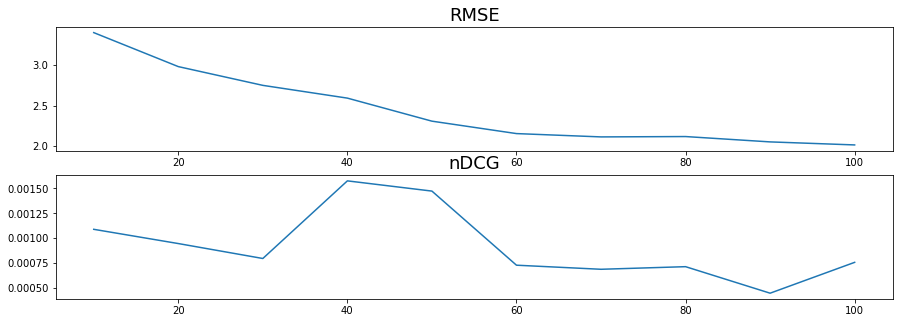

In [224]:
plt.figure(figsize=(15,5))
plt.subplot(2, 1, 1)
plt.title('RMSE', fontsize=18)
plt.plot(D, rmses)
plt.subplot(2, 1, 2)
plt.title('nDCG', fontsize=18)
plt.plot(D, ndcgs)

Выберем d = 50.

**8. (0.5 балла)** Постройте рекомендации с оптимальными значениями гиперпараметров из п. 7 и вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1, 2 и 3 (по отдельности). Ощутимо ли различие между ними? Как это можно объяснить?

In [225]:
prediction = SGD_prediction(train_sm, lmbd=3, mu=0.1, d=50)

/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [227]:
rmse_group2 = rmse_score(group2_test_sm, prediction[list(group2)])
ndcg_group2 = ndcg_score(group2_test_sm, prediction[list(group2)])
rmse_group3 = rmse_score(group3_test_sm, prediction[list(group3)])
ndcg_group3 = ndcg_score(group3_test_sm, prediction[list(group3)])
print('group 2:')
print('RMSE: {}, nDCG: {}'.format(rmse_group2, ndcg_group2))
print('group3:')
print('RMSE: {}, nDCG: {}'.format(rmse_group3, ndcg_group3))

group 2:
RMSE: 2.3012277928, nDCG: 0.0
group3:
RMSE: 2.40945278154, nDCG: 0.000496423745101


**Ответ:** На второй группе nDCG становится нулем. Это происходит, во-первых, из-за того, что там всего 50 пользователей и у каждого всего 5 оценок на 10000 фильмов - вероятность того, что фильмы, рекомендованные пользователю, им просмотрены и оценены, очень мала, и во-вторых, потому, что фильмы, которые смотрели пользователи из группы 2, непопулярны, и алгоритм не смог нормально на них настроиться. То, что RMSE на первой группе немного меньше, скорее всего, случайность.

**9. (0.5 балла)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения). Постройте рекомендации с оптимальными значениями гиперпараметров  и вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1, 2 и 3 (по отдельности). Как полученные значения отличаются от аналогичных из п. 8? Как это можно объяснить?

In [ ]:
# Your code here

**Ответ:**

**10. (0.5 балла)** Сформируйте обучающие, валидационные и тестовые матрицы объект-признак для следующих наборов признаков:
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование);
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + средняя оценка пользователя;
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + жанры фильма;
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + жанры фильма + киноперсоны.

In [ ]:
# Your code here

**11. (1.5 балла)** Для каждой из выборок из предыдущего пункта постройте рекомендации при помощи факторизационных машин из библиотеки [LibFM](http://libfm.org) с использованием метода оптимизации ALS, подобрав оптимальную размерность разложения на валидационной выборке. Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для оптимальных значений гиперпараметров. Какой набор признаков оказался самым удачным? Как это можно объяснить?
При выполнении данного задания вам также может пригодиться библиотека [pywFM](https://github.com/jfloff/pywFM), являющаяся python-обёрткой над LibFM.

In [ ]:
# Your code here

**Ответ:**

**12. (1 балл)** Приведите сравнение качества всех моделей, руководствуясь значениями описанных метрик. Какие из моделей оказались лучше других по каждой из метрик? Как это можно объяснить?

**Ответ**: